In [ ]:
import json

# Provided data
data = {"username":"uom200088d","key":"b8a8f1354ecced4d47d7e80e628e11f0"}

# Write data to kaggle.json
with open('kaggle.json', 'w') as file:
    json.dump(data, file)

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c store-sales-time-series-forecasting
import zipfile

# Create a ZipFile Object
with zipfile.ZipFile('store-sales-time-series-forecasting.zip') as zip_obj:
   # Extract all the contents of zip file to current directory
   zip_obj.extractall('store_sales_data')

%cd store_sales_data

100% 21.4M/21.4M [00:02<00:00, 20.6MB/s]
100% 21.4M/21.4M [00:02<00:00, 11.1MB/s]
/content/store_sales_data


In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 784.8/784.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.0/275.0 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 16.4 MB/s eta

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv("train.csv", parse_dates=["date"])
test = pd.read_csv("test.csv", parse_dates=["date"])

oil = pd.read_csv("oil.csv", parse_dates=["date"]).rename(columns={"dcoilwtico": "oil"})
store = pd.read_csv("stores.csv")
transaction = pd.read_csv("transactions.csv", parse_dates=["date"])
holiday = pd.read_csv("holidays_events.csv", parse_dates=["date"])

In [ ]:
num_family = train.family.nunique()
num_store = train.store_nbr.nunique()
num_ts = train.groupby(["store_nbr", "family"]).ngroups
train_start = train.date.min().date()
train_end = train.date.max().date()
num_train_date = train.date.nunique()
train_len = (train_end - train_start).days + 1
test_start = test.date.min().date()
test_end = test.date.max().date()
num_test_date = test.date.nunique()
test_len = (test_end - test_start).days + 1

In [ ]:
missing_dates = pd.date_range(train_start, train_end).difference(train.date.unique())
missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()

unique_dp_count = train.groupby(["store_nbr", "family"]).date.count().unique().tolist()

In [ ]:
# reindex training data
multi_idx = pd.MultiIndex.from_product(
    [pd.date_range(train_start, train_end), train.store_nbr.unique(), train.family.unique()],
    names=["date", "store_nbr", "family"],
)
train = train.set_index(["date", "store_nbr", "family"]).reindex(multi_idx).reset_index()

# fill missing values with 0s
train[["sales", "onpromotion"]] = train[["sales", "onpromotion"]].fillna(0.)
train.id = train.id.interpolate(method="linear") # interpolate linearly as a filler for the 'id'

In [ ]:
# reindex oil data
oil = oil.merge(
    pd.DataFrame({"date": pd.date_range(train_start, test_end)}),
    on="date",
    how="outer",
).sort_values("date", ignore_index=True)

# fill missing values using linear interpolation
oil.oil = oil.oil.interpolate(method="linear", limit_direction="both")

In [ ]:
# compute total sales for each store
store_sales = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()

# reindex transaction data
transaction = transaction.merge(
    store_sales,
    on=["date", "store_nbr"],
    how="outer",
).sort_values(["date", "store_nbr"], ignore_index=True)

# fill missing values with 0s for days with zero sales
transaction.loc[transaction.sales.eq(0), "transactions"] = 0.
transaction = transaction.drop(columns=["sales"])

# fill remaining missing values using linear interpolation
transaction.transactions = transaction.groupby("store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both")
)

In [ ]:
def process_holiday(s):
    if "futbol" in s:
        return "futbol"
    to_remove = list(set(store.city.str.lower()) | set(store.state.str.lower()))
    for w in to_remove:
        s = s.replace(w, "")
    return s

In [ ]:
holiday.description = holiday.apply(
    lambda x: x.description.lower().replace(x.locale_name.lower(), ""),
    axis=1,
).apply(
    process_holiday
).replace(
    r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b", "", regex=True,
).replace(
    r"\s+|-", " ", regex=True,
).str.strip()

holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,fundacion,False
1,2012-04-01,Holiday,Regional,Cotopaxi,provincializacion,False
2,2012-04-12,Holiday,Local,Cuenca,fundacion,False
3,2012-04-14,Holiday,Local,Libertad,cantonizacion,False
4,2012-04-21,Holiday,Local,Riobamba,cantonizacion,False


In [ ]:
# remove transferred holidays
holiday = holiday[holiday.transferred.eq(False)]

#########################################
### Saturdays designated as work days ###
#########################################
work_days = holiday[holiday.type.eq("Work Day")]
work_days = work_days[["date", "type"]].rename(
    columns={"type": "work_day"}
).reset_index(drop=True)
work_days.work_day = work_days.work_day.notna().astype(int)
# remove work days after extracting above
holiday = holiday[holiday.type!="Work Day"].reset_index(drop=True)

###################################
### local holidays (city level) ###
###################################
local_holidays = holiday[holiday.locale.eq("Local")]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "city"}
).reset_index(drop=True)
local_holidays = local_holidays[~local_holidays.duplicated()]
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")

#######################################
### regional holidays (state level) ###
#######################################
regional_holidays = holiday[holiday.locale.eq("Regional")]
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "state", "description": "provincializacion"}
).reset_index(drop=True)
regional_holidays.provincializacion = regional_holidays.provincializacion.eq("provincializacion").astype(int)

#########################
### national holidays ###
#########################
national_holidays = holiday[holiday.locale.eq("National")]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")
# different national holidays may fall on the same day
national_holidays = national_holidays.groupby("date").sum().reset_index()
# shorten name for visualization purposes later
national_holidays = national_holidays.rename(columns={"nat_primer grito independencia": "nat_primer grito"})

national_holidays.head()

,date,nat_batalla,nat_black friday,nat_carnaval,nat_cyber monday,nat_dia difuntos,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo
0,2012-08-10,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2012-10-12,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2012-11-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2012-11-03,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2012-12-21,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
# keep selected national holidays with larger impacts on sales
selected_holidays = [
    "nat_terremoto", "nat_navidad", "nat_dia la madre", "nat_dia trabajo",
    "nat_primer dia ano", "nat_futbol", "nat_dia difuntos",
]
keep_national_holidays = national_holidays[["date", *selected_holidays]]

# combine all the datasets
data = pd.concat(
    [train, test], axis=0, ignore_index=True,
).merge(
    transaction, on=["date", "store_nbr"], how="left",
).merge(
    oil, on="date", how="left",
).merge(
    store, on="store_nbr", how="left",
).merge(
    work_days, on="date", how="left",
).merge(
    keep_national_holidays, on="date", how="left",
).merge(
    regional_holidays, on=["date","state"], how="left",
).merge(
    local_holidays, on=["date","city"], how="left",
).sort_values(["date", "store_nbr", "family"], ignore_index=True)

# fill columns with 0s to indicate absence of holidays/events
data[["work_day", *selected_holidays]] = data[["work_day", *selected_holidays]].fillna(0)

# include date-related future covariates
data["day"] = data.date.dt.day
data["month"] = data.date.dt.month
data["year"] = data.date.dt.year
data["day_of_week"] = data.date.dt.dayofweek
data["day_of_year"] = data.date.dt.dayofyear
data["week_of_year"] = data.date.dt.isocalendar().week.astype(int)
data["date_index"] = data.date.factorize()[0] # sort by date above before computing this

# to impute days with zero sales using linear interpolation later
zero_sales_dates = missing_dates + [f"{j}-01-01" for j in range(2013, 2018)]
data.loc[(data.date.isin(zero_sales_dates))&(data.sales.eq(0))&(data.onpromotion.eq(0)), ["sales", "onpromotion"]] = np.nan

# add prefixes for clarity
data.store_nbr = data.store_nbr.apply(lambda x: (f"store_nbr_{x}"))
data.cluster = data.cluster.apply(lambda x: (f"cluster_{x}"))
data.type = data.type.apply(lambda x: (f"type_{x}"))

# add prefixes to ensure no duplicate values between 'city' and 'state'
data.city = data.city.apply(lambda x: (f"{x.lower()}"))
data.state = data.state.apply(lambda x: (f"{x.lower()}"))

data.head()

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,city,state,...,loc_cantonizacion,loc_fundacion,loc_independencia,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,NaN,NaN,0.0,93.14,quito,pichincha,...,NaN,NaN,NaN,1,1,2013,1,1,1,0
1,2013-01-01,store_nbr_1,BABY CARE,1.0,NaN,NaN,0.0,93.14,quito,pichincha,...,NaN,NaN,NaN,1,1,2013,1,1,1,0
2,2013-01-01,store_nbr_1,BEAUTY,2.0,NaN,NaN,0.0,93.14,quito,pichincha,...,NaN,NaN,NaN,1,1,2013,1,1,1,0
3,2013-01-01,store_nbr_1,BEVERAGES,3.0,NaN,NaN,0.0,93.14,quito,pichincha,...,NaN,NaN,NaN,1,1,2013,1,1,1,0
4,2013-01-01,store_nbr_1,BOOKS,4.0,NaN,NaN,0.0,93.14,quito,pichincha,...,NaN,NaN,NaN,1,1,2013,1,1,1,0


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import numpy as np

# Assuming df is your DataFrame
df = data

# Select columns to transform
cols_to_transform = ['sales', 'onpromotion']

# Fill missing values with linear interpolation
df[cols_to_transform] = df[cols_to_transform].interpolate(method='linear')

In [ ]:
df.fillna(0, inplace=True)

In [ ]:
df = df.sort_values('id')
df.head()

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,city,state,...,loc_cantonizacion,loc_fundacion,loc_independencia,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,0.0,0.0,0.0,93.14,quito,pichincha,...,0.0,0.0,0.0,1,1,2013,1,1,1,0
1,2013-01-01,store_nbr_1,BABY CARE,1.0,0.0,0.0,0.0,93.14,quito,pichincha,...,0.0,0.0,0.0,1,1,2013,1,1,1,0
2,2013-01-01,store_nbr_1,BEAUTY,2.0,0.0,0.0,0.0,93.14,quito,pichincha,...,0.0,0.0,0.0,1,1,2013,1,1,1,0
3,2013-01-01,store_nbr_1,BEVERAGES,3.0,0.0,0.0,0.0,93.14,quito,pichincha,...,0.0,0.0,0.0,1,1,2013,1,1,1,0
4,2013-01-01,store_nbr_1,BOOKS,4.0,0.0,0.0,0.0,93.14,quito,pichincha,...,0.0,0.0,0.0,1,1,2013,1,1,1,0


In [ ]:
df = pd.get_dummies(df, columns=['type'])
df.head()

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,city,state,...,year,day_of_week,day_of_year,week_of_year,date_index,type_type_A,type_type_B,type_type_C,type_type_D,type_type_E
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,0.0,0.0,0.0,93.14,quito,pichincha,...,2013,1,1,1,0,0,0,0,1,0
1,2013-01-01,store_nbr_1,BABY CARE,1.0,0.0,0.0,0.0,93.14,quito,pichincha,...,2013,1,1,1,0,0,0,0,1,0
2,2013-01-01,store_nbr_1,BEAUTY,2.0,0.0,0.0,0.0,93.14,quito,pichincha,...,2013,1,1,1,0,0,0,0,1,0
3,2013-01-01,store_nbr_1,BEVERAGES,3.0,0.0,0.0,0.0,93.14,quito,pichincha,...,2013,1,1,1,0,0,0,0,1,0
4,2013-01-01,store_nbr_1,BOOKS,4.0,0.0,0.0,0.0,93.14,quito,pichincha,...,2013,1,1,1,0,0,0,0,1,0


In [ ]:
df = df.drop(['city', 'state','cluster'], axis=1)
df.head()

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,work_day,nat_terremoto,...,year,day_of_week,day_of_year,week_of_year,date_index,type_type_A,type_type_B,type_type_C,type_type_D,type_type_E
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,0.0,0.0,0.0,93.14,0.0,0.0,...,2013,1,1,1,0,0,0,0,1,0
1,2013-01-01,store_nbr_1,BABY CARE,1.0,0.0,0.0,0.0,93.14,0.0,0.0,...,2013,1,1,1,0,0,0,0,1,0
2,2013-01-01,store_nbr_1,BEAUTY,2.0,0.0,0.0,0.0,93.14,0.0,0.0,...,2013,1,1,1,0,0,0,0,1,0
3,2013-01-01,store_nbr_1,BEVERAGES,3.0,0.0,0.0,0.0,93.14,0.0,0.0,...,2013,1,1,1,0,0,0,0,1,0
4,2013-01-01,store_nbr_1,BOOKS,4.0,0.0,0.0,0.0,93.14,0.0,0.0,...,2013,1,1,1,0,0,0,0,1,0


In [ ]:
df.columns

Index(['date', 'store_nbr', 'family', 'id', 'sales', 'onpromotion',
       'transactions', 'oil', 'work_day', 'nat_terremoto', 'nat_navidad',
       'nat_dia la madre', 'nat_dia trabajo', 'nat_primer dia ano',
       'nat_futbol', 'nat_dia difuntos', 'provincializacion',
       'loc_cantonizacion', 'loc_fundacion', 'loc_independencia', 'day',
       'month', 'year', 'day_of_week', 'day_of_year', 'week_of_year',
       'date_index', 'type_type_A', 'type_type_B', 'type_type_C',
       'type_type_D', 'type_type_E'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler object
scaler = MinMaxScaler()

# List of columns to scale
cols_to_scale = ['onpromotion','transactions', 'oil', 'work_day', 'day',
       'month', 'year', 'day_of_week', 'day_of_year', 'week_of_year',
       'date_index']

# Apply scaler to the columns
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
df.head()

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,work_day,nat_terremoto,...,year,day_of_week,day_of_year,week_of_year,date_index,type_type_A,type_type_B,type_type_C,type_type_D,type_type_E
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,0.0,0.0,0.0,0.792965,0.0,0.0,...,0.0,0.166667,0.0,0.0,0.0,0,0,0,1,0
1,2013-01-01,store_nbr_1,BABY CARE,1.0,0.0,0.0,0.0,0.792965,0.0,0.0,...,0.0,0.166667,0.0,0.0,0.0,0,0,0,1,0
2,2013-01-01,store_nbr_1,BEAUTY,2.0,0.0,0.0,0.0,0.792965,0.0,0.0,...,0.0,0.166667,0.0,0.0,0.0,0,0,0,1,0
3,2013-01-01,store_nbr_1,BEVERAGES,3.0,0.0,0.0,0.0,0.792965,0.0,0.0,...,0.0,0.166667,0.0,0.0,0.0,0,0,0,1,0
4,2013-01-01,store_nbr_1,BOOKS,4.0,0.0,0.0,0.0,0.792965,0.0,0.0,...,0.0,0.166667,0.0,0.0,0.0,0,0,0,1,0


In [ ]:
# Create a multi-level dictionary to store DataFrames
data = {}

# Iterate over unique families
for family in df['family'].unique():
    data[family] = {}

    # Get rows for the current family
    family_df = df[df['family'] == family]

    # Iterate over unique store numbers within the current family
    for store_nbr in family_df['store_nbr'].unique():

        # Get rows for the current store number and store in dictionary
        data[family][store_nbr] = family_df[family_df['store_nbr'] == store_nbr]


In [ ]:
families = df['family'].unique()
stores = df['store_nbr'].unique()

In [ ]:
data['AUTOMOTIVE']['store_nbr_42'].head()

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,work_day,nat_terremoto,...,year,day_of_week,day_of_year,week_of_year,date_index,type_type_A,type_type_B,type_type_C,type_type_D,type_type_E
1353,2013-01-01,store_nbr_42,AUTOMOTIVE,1188.0,18.002459,0.0,0.0,0.792965,0.0,0.0,...,0.0,0.166667,0.000000,0.0,0.000000,0,0,0,1,0
3135,2013-01-02,store_nbr_42,AUTOMOTIVE,2970.0,0.000000,0.0,0.0,0.792965,0.0,0.0,...,0.0,0.333333,0.002740,0.0,0.000587,0,0,0,1,0
4917,2013-01-03,store_nbr_42,AUTOMOTIVE,4752.0,0.000000,0.0,0.0,0.790951,0.0,0.0,...,0.0,0.500000,0.005479,0.0,0.001174,0,0,0,1,0
6699,2013-01-04,store_nbr_42,AUTOMOTIVE,6534.0,0.000000,0.0,0.0,0.792728,0.0,0.0,...,0.0,0.666667,0.008219,0.0,0.001762,0,0,0,1,0
8481,2013-01-05,store_nbr_42,AUTOMOTIVE,8316.0,0.000000,0.0,0.0,0.793044,1.0,0.0,...,0.0,0.833333,0.010959,0.0,0.002349,0,0,0,1,0


In [ ]:
data['AUTOMOTIVE']['store_nbr_42'].tail()

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,work_day,nat_terremoto,...,year,day_of_week,day_of_year,week_of_year,date_index,type_type_A,type_type_B,type_type_C,type_type_D,type_type_E
3028971,2017-08-27,store_nbr_42,AUTOMOTIVE,3021678.0,3.0,0.0,0.0,0.244305,0.0,0.0,...,1.0,1.000000,0.652055,0.634615,0.997651,0,0,0,1,0
3030753,2017-08-28,store_nbr_42,AUTOMOTIVE,3023460.0,3.0,0.0,0.0,0.239370,0.0,0.0,...,1.0,0.000000,0.654795,0.653846,0.998238,0,0,0,1,0
3032535,2017-08-29,store_nbr_42,AUTOMOTIVE,3025242.0,3.0,0.0,0.0,0.240081,0.0,0.0,...,1.0,0.166667,0.657534,0.653846,0.998826,0,0,0,1,0
3034317,2017-08-30,store_nbr_42,AUTOMOTIVE,3027024.0,3.0,0.0,0.0,0.234158,0.0,0.0,...,1.0,0.333333,0.660274,0.653846,0.999413,0,0,0,1,0
3036099,2017-08-31,store_nbr_42,AUTOMOTIVE,3028806.0,3.0,0.0,0.0,0.249556,0.0,0.0,...,1.0,0.500000,0.663014,0.653846,1.000000,0,0,0,1,0


In [ ]:
data['AUTOMOTIVE']['store_nbr_42'].columns

Index(['date', 'store_nbr', 'family', 'id', 'sales', 'onpromotion',
       'transactions', 'oil', 'work_day', 'nat_terremoto', 'nat_navidad',
       'nat_dia la madre', 'nat_dia trabajo', 'nat_primer dia ano',
       'nat_futbol', 'nat_dia difuntos', 'provincializacion',
       'loc_cantonizacion', 'loc_fundacion', 'loc_independencia', 'day',
       'month', 'year', 'day_of_week', 'day_of_year', 'week_of_year',
       'date_index', 'type_type_A', 'type_type_B', 'type_type_C',
       'type_type_D', 'type_type_E'],
      dtype='object')

In [ ]:
cols_to_scale = ['transactions', 'oil', 'work_day', 'nat_terremoto', 'day',
       'month', 'year', 'day_of_week', 'day_of_year', 'week_of_year']


In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries

In [ ]:
from darts.dataprocessing.transformers import Scaler

def log_tr(x):
  return np.log(x+1)

def inv_log(y):
  return np.exp(y)-1

data_scaled = {}
scalers = {}
for family in families:
  temp = {}
  temp_scaler = {}
  for store in stores:
    dataframe = data[family][store]

    sales = TimeSeries.from_dataframe(dataframe, 'date', 'sales')
    sales = sales.map(log_tr)
    scaler = Scaler()
    scaled_sales = scaler.fit_transform(sales)

    temp[store] = scaled_sales
    temp_scaler[store] = scaler

  data_scaled[family] = temp
  scalers[family] = temp_scaler

<Axes: xlabel='date'>

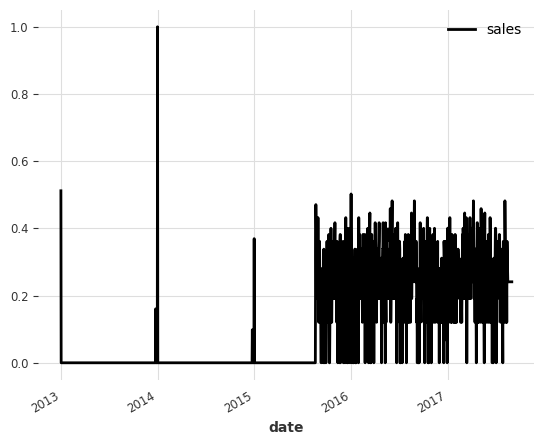

In [ ]:
data_scaled['AUTOMOTIVE']['store_nbr_42'].plot()

In [ ]:
data_stacked = {}
for family in families:
  stacked = data_scaled[family][stores[0]]
  for store in stores[1:]:
    stacked = stacked.stack(data_scaled[family][store])
  data_stacked[family] = stacked

<Axes: xlabel='date'>

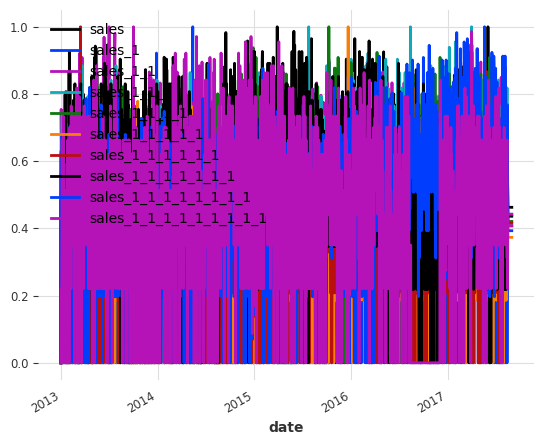

In [ ]:
data_stacked['AUTOMOTIVE'].plot()

In [ ]:
shop_names = {stores[0]:'sales'}
name = 'sales'
for store in stores[1:]:
  name = name + '_1'
  shop_names[store] = name

<Axes: xlabel='date'>

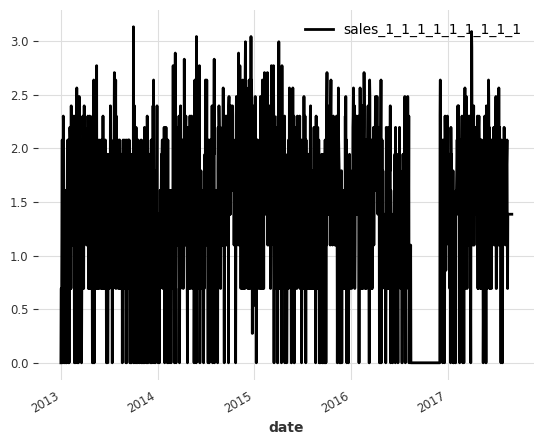

In [ ]:
scalers['AUTOMOTIVE']['store_nbr_18'].inverse_transform(data_stacked['AUTOMOTIVE'][shop_names['store_nbr_18']]).plot()

In [ ]:
store_transactions = []
for store in stores:
  temp = data[families[0]][store]
  ts_tr = TimeSeries.from_dataframe(temp, 'date', 'transactions')
  store_transactions.append(ts_tr)

In [ ]:
tr_series = store_transactions[0]
for series in store_transactions[1:]:
  tr_series = tr_series.stack(series)

<Axes: xlabel='date'>

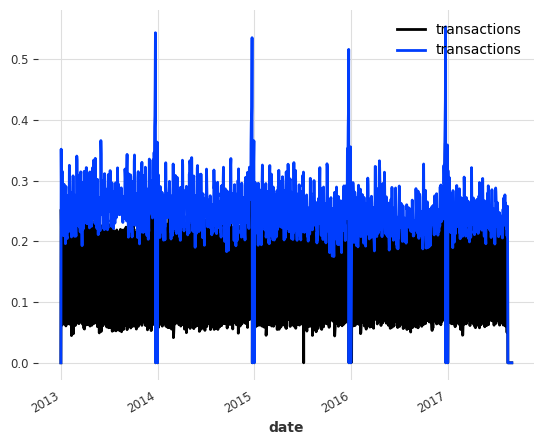

In [ ]:
store_transactions[0].plot()
store_transactions[-1].plot()

<Axes: xlabel='date'>

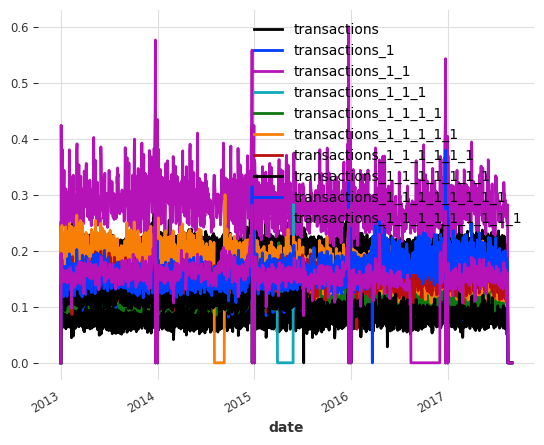

In [ ]:
tr_series.plot()

In [ ]:
holidays = []
for store in stores:
  temp = data[families[0]][store]
  #'provincializacion', 'loc_cantonizacion', 'loc_fundacion', 'loc_independencia'
  ts_holiday_pr = TimeSeries.from_dataframe(temp, 'date', 'provincializacion')
  ts_holiday_ca = TimeSeries.from_dataframe(temp, 'date', 'loc_cantonizacion')
  ts_holiday_fu = TimeSeries.from_dataframe(temp, 'date', 'loc_fundacion')
  ts_holiday_in = TimeSeries.from_dataframe(temp, 'date', 'loc_independencia')
  ts_holiday = ts_holiday_pr.stack(ts_holiday_ca.stack(ts_holiday_fu.stack(ts_holiday_in)))
  holidays.append(ts_holiday)

<Axes: xlabel='date'>

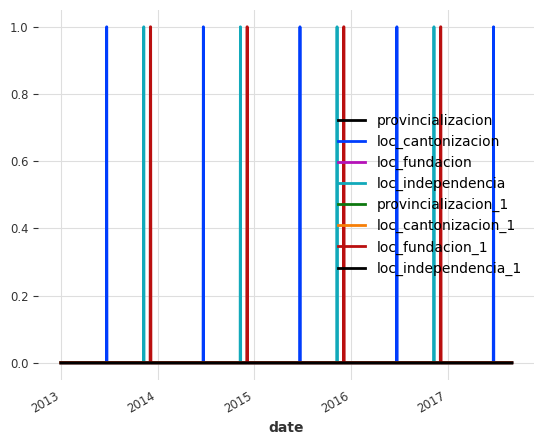

In [ ]:
holidays[10].stack(holidays[0]).plot()

In [ ]:
holiday_series = holidays[0]
for series in holidays[1:]:
  holiday_series = holiday_series.stack(series)

<Axes: xlabel='date'>

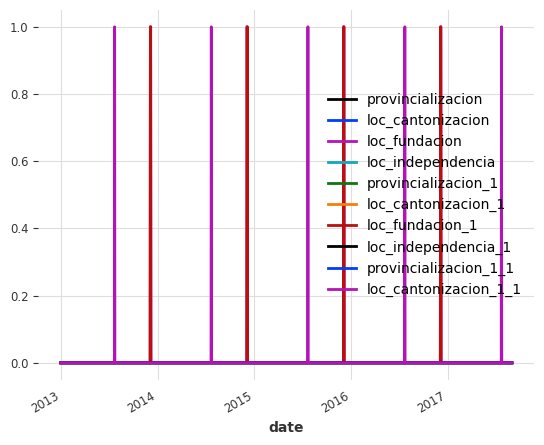

In [ ]:
holiday_series.plot()

In [ ]:
from darts.models.filtering.moving_average_filter import MovingAverageFilter

temp = data[families[0]][store]

cols = ['onpromotion', 'oil', 'work_day', 'nat_terremoto', 'nat_navidad',
      'nat_dia la madre', 'nat_dia trabajo', 'nat_primer dia ano',
      'nat_futbol', 'nat_dia difuntos', 'day',
      'month', 'year', 'day_of_week', 'day_of_year', 'week_of_year',
      'date_index', 'type_type_A', 'type_type_B', 'type_type_C',
      'type_type_D', 'type_type_E']

ts = TimeSeries.from_dataframe(temp, 'date', cols[0])
for col in cols[1:]:
  if col == 'oil':
    temp_series = TimeSeries.from_dataframe(temp, 'date', col)
    ma_model = MovingAverageFilter(window=14)
    moving_average_series = ma_model.filter(temp_series)
    ts = ts.stack(moving_average_series)
  else:
    ts = ts.stack(TimeSeries.from_dataframe(temp, 'date', col))

<Axes: xlabel='date'>

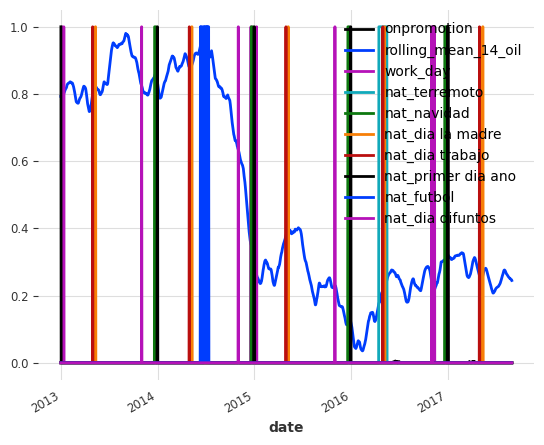

In [ ]:
ts.plot()

In [ ]:
future_covs = ts.stack(holiday_series)

In [ ]:
train_series,test_series = data_stacked['AUTOMOTIVE'][:-16],data_stacked['AUTOMOTIVE'][-16:]

In [ ]:
train,val = train_series.split_before(pd.Timestamp("20170415"))

<Axes: xlabel='date'>

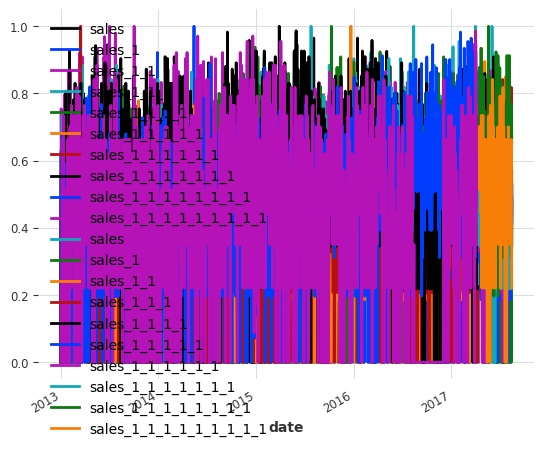

In [ ]:
train.plot()
val.plot()

In [ ]:
onlyPast = tr_series.stack(future_covs)

In [ ]:
train_set = []

for family in families:
  train_ts = data_stacked[family][:-16]
  train_small,val = train_ts.split_before(pd.Timestamp("20170415"))
  train_set.append(train_small)

In [ ]:
from darts.models.forecasting.nhits import NHiTSModel

model = NHiTSModel(input_chunk_length = 30, output_chunk_length = 16,num_stacks=5, num_blocks=2, num_layers=4)
model.fit(train_set, epochs=5, past_covariates=[onlyPast for i in families])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 81.9 M
---------------------------------------------------
76.5 M    Trainable params
5.3 M     Non-trainable params
81.9 M    Total params
327.444   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

NHiTSModel(num_stacks=5, num_blocks=2, num_layers=4, layer_widths=512, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1, activation=ReLU, MaxPool1d=True, input_chunk_length=30, output_chunk_length=16)

In [ ]:
pred = model.predict(series=train_set,past_covariates=[onlyPast for i in families],n=123)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

<Axes: xlabel='date'>

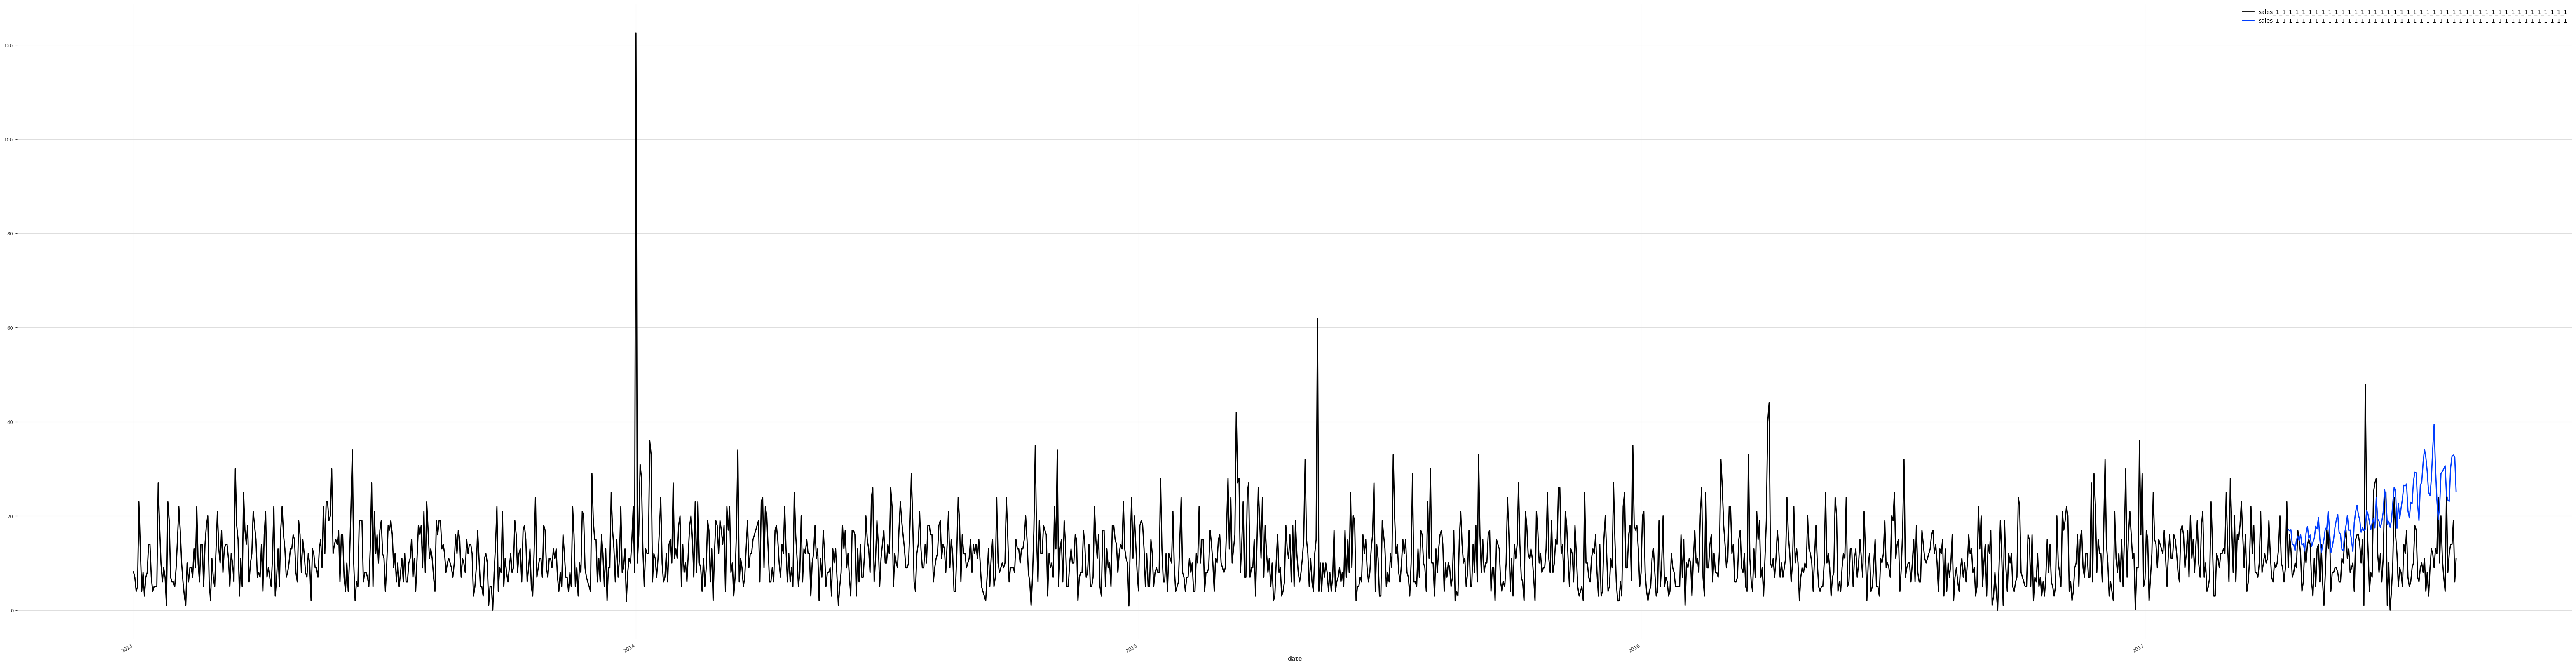

In [ ]:
plt.figure(figsize=(80, 20))
scalers['AUTOMOTIVE']['store_nbr_50'].inverse_transform(train_series[shop_names['store_nbr_50']]).map(inv_log).plot()
scalers['AUTOMOTIVE']['store_nbr_50'].inverse_transform(pred[0][shop_names['store_nbr_50']]).map(inv_log).plot()

In [ ]:
from darts.metrics import rmsle

errors = []

for store in stores:
  series1 = scalers['AUTOMOTIVE'][store].inverse_transform(train_series[shop_names[store]]).map(np.expm1)
  series2 = scalers['AUTOMOTIVE'][store].inverse_transform(pred[0][shop_names[store]]).map(np.expm1)
  error = rmsle(series1, series2)
  errors.append(error)

print('avg',sum(errors)/len(errors))
print('max',max(errors))
print('min',min(errors))

avg 0.829801023696676
max 2.7013842594767428
min 0.44759033460458714


In [ ]:
test['sales'] = 0

In [ ]:
test

,id,date,store_nbr,family,onpromotion,sales
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0
1,3000889,2017-08-16,1,BABY CARE,0,0
2,3000890,2017-08-16,1,BEAUTY,2,0
3,3000891,2017-08-16,1,BEVERAGES,20,0
4,3000892,2017-08-16,1,BOOKS,0,0
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,0
28508,3029396,2017-08-31,9,PREPARED FOODS,0,0
28509,3029397,2017-08-31,9,PRODUCE,1,0
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,0


In [ ]:
families

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [ ]:
del data

In [ ]:
full_train_set = []

for family in families:
  train_ts = data_stacked[family][:-16]
  full_train_set.append(train_ts)

In [ ]:
from darts.models.forecasting.nhits import NHiTSModel

model = NHiTSModel(input_chunk_length = 10, output_chunk_length = 5,num_stacks=5, num_blocks=2, num_layers=4)
model.fit(full_train_set, epochs=50, past_covariates=[onlyPast for i in families])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 42.6 M
---------------------------------------------------
40.8 M    Trainable params
1.8 M     Non-trainable params
42.6 M    Total params
170.380   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


NHiTSModel(num_stacks=5, num_blocks=2, num_layers=4, layer_widths=512, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1, activation=ReLU, MaxPool1d=True, input_chunk_length=10, output_chunk_length=5)

In [ ]:
pred = model.predict(series=full_train_set,past_covariates=[onlyPast for i in families],n=16)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
st = [int(store[10:]) for store in stores]
test_copy = test.copy()
for fam in range(len(families)):
  for store in stores:
    series = scalers[families[fam]][store].inverse_transform(pred[fam][shop_names[store]]).map(np.expm1)
    temp = series.pd_dataframe()
    temp = temp.reset_index()
    for i in range(len(temp)):
      date = temp.loc[i]['date']
      sale = temp.loc[i][shop_names[store]]
      test_copy.loc[(test_copy['date'] == date) & (test_copy['family'] == families[fam]) & (test_copy['store_nbr'] == int(store[10:])),'sales'] = sale if sale > 0 else 0


test_copy.head()


,id,date,store_nbr,family,onpromotion,sales
0,3000888,2017-08-16,1,AUTOMOTIVE,0,3.822319
1,3000889,2017-08-16,1,BABY CARE,0,0.065417
2,3000890,2017-08-16,1,BEAUTY,2,3.460777
3,3000891,2017-08-16,1,BEVERAGES,20,2051.790427
4,3000892,2017-08-16,1,BOOKS,0,0.114413


In [ ]:
submission = test_copy[['id','sales']]
submission.head()

,id,sales
0,3000888,3.822319
1,3000889,0.065417
2,3000890,3.460777
3,3000891,2051.790427
4,3000892,0.114413


In [ ]:
submission.to_csv('submission.csv', index=False)